# Text Analysis - Workshop Notebook

Welcome to the completed notebook for the Text Analysis Workshop. In here, you'll find all the code presented in during the workshop, along with some comments and explanations. Feel free to review your answers after the workshop.

### Aims 
In this notebook, we'll be exploring tweets to @Apple. Our end-goal is to be able to extract the sentiment of each tweet (i.e, is the content of the tweet rather positive, neutral, or negative)? Along the way, we'll be introducing a collection of notions which will help us get there.

### Agenda 
In this workshop, we will:
* Load, explore, and perform some basic manipulations on text data
* Pre-process the data; in particular, we'll be looking at:
    * Normalisation considerations
    * Tokenization strategies
    * Stopwords removal
* Extract sentiment (or *polarity*) from our processed tweets
* Demonstrate ways to visualise sentiment and tokens

### Data

We will be using a collection of 9000+ tweets scraped using the Twitter API. In addition to the raw tweet, each entry in the dataset contains additional information - number of likes, number of retweets, username of the author, etc. The data can be found [here](https://github.com/DecodedCo/data-resources/tree/master/text-analysis).

## Libraries

In [1]:
import nltk  # our go-to tool for text analysis
import pandas as pd  # for imports and data manipulation
import re  # for regular expression filtering
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # sentiment analysis tool
import seaborn as sns  # for plotting
from collections import Counter  # for word frequencies
import matplotlib.pyplot as plt  # for visualisation
from pandas.core.common import flatten  # used to collapse lists of lists

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Data sourcing

In [3]:
# raw tweets
df = pd.read_csv('apple_tweets.csv')

## Data exploration

In [4]:
# have a look at the data
df.sample(3)

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
4546,1.213782e+08,1.090000e+18,1548755769,varindiamag,Red alert for #Apple Devices Using #FaceTime a...,Twitter Web Client,184,NaN,NaN,NaN,...,32503,7966,1268126666,False,http://t.co/Z5f68dSULl,http://www.varindia.com,en,https://pbs.twimg.com/profile_banners/12137819...,http://abs.twimg.com/images/themes/theme3/bg.gif,http://pbs.twimg.com/profile_images/6096378994...
1078,8.800000e+17,1.090000e+18,1548831741,GetSlayedByKass,@Apple Can y’all send me some money so I can s...,Twitter for iPhone,83,1.090000e+18,380749300.0,Apple,...,530,222,1498620575,False,https://t.co/73bdsatsQH,http://www.instagram.com/getslayedbykass,en,https://pbs.twimg.com/profile_banners/87990458...,NaN,http://pbs.twimg.com/profile_images/1062330223...
8892,4.837672e+07,1.090000e+18,1548613474,jeffbeartooth,the touchbar is trash @apple https://t.co/Uxdv...,Twitter for iPhone,28,NaN,NaN,NaN,...,1498,1745,1245337624,False,https://t.co/Ktlfsrss5l,http://www.beartooth.com,en,https://pbs.twimg.com/profile_banners/48376715...,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/1008409790...


In [5]:
# check how much data we have
df.shape

(9991, 88)

In [6]:
# get basic info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 88 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  9991 non-null   float64
 1   status_id                9991 non-null   float64
 2   created_at               9991 non-null   int64  
 3   screen_name              9991 non-null   object 
 4   text                     9991 non-null   object 
 5   source                   9991 non-null   object 
 6   display_text_width       9991 non-null   int64  
 7   reply_to_status_id       4382 non-null   float64
 8   reply_to_user_id         5988 non-null   float64
 9   reply_to_screen_name     5988 non-null   object 
 10  is_quote                 9991 non-null   bool   
 11  is_retweet               9991 non-null   bool   
 12  favorite_count           9991 non-null   int64  
 13  retweet_count            9991 non-null   int64  
 14  hashtags                

In [7]:
# keep only the columns of interest
data = df[['user_id', 'screen_name', 'text', 'retweet_count', 'favorite_count', 'verified']]

### Challenge: extracting some basic statistics from our data

Display:

1. The tweet with the highest number of retweets
2. The number of tweets posted from verified accounts
3. The most common screen name
4. The number of tweets with more than 50 likes (`favourite_count`)

In [8]:
# 1. Tweet with the highest number of retweets
data[data['retweet_count'] == data['retweet_count'].max()]

,user_id,screen_name,text,retweet_count,favorite_count,verified
9039,3.216702e+09,Bo0mh4cks,"If iOS 13 looks like this, I’d be happy. *My O...",206,563,False


In [9]:
# 2. Number of tweets posted from verified accounts
print(sum(data['verified']))

340


In [10]:
# 3. Most common screen name
print(data['screen_name'].value_counts().index[0])

Chappers2013


In [11]:
# 4. Number of tweets with more than 50 likes
print(data[data['favorite_count'] > 50].shape[0])

36


In [12]:
# an interesting tweet
data['text'][680]

'✨🍎@Apple : Apple was warned about the FaceTime eavesdropping bug last week https://t.co/zry3BCizbj #Tech #Apple $AAPL #Technology #TechNews https://t.co/ip8dhXg48K'

## Data processing

### 0. Normalisation

In the following, we'll be using some regular expressions to filter text and extract patterns. Feel free to refer to [this regex cheat sheet](https://www.dataquest.io/blog/regex-cheatsheet/) in a new tab!

In [13]:
text = "Hello @apple, can you please roll out that new feature that @samsung has? #thankyou #apple #samsung"

In [14]:
# remove mentions using regular expressions
text = re.sub('@[\w]+', '', text)
print(text)

Hello , can you please roll out that new feature that  has? #thankyou #apple #samsung


In [15]:
# remove hashtags using regular expressions
text = re.sub('#[\w]+', '', text)
print(text)

Hello , can you please roll out that new feature that  has?   


In [16]:
# define a function that removes hashtags, mentions, and stock names, as well as links and special characters

def regex_cleaner(text):
    # remove hashtags (#apple), mentions (@Apple) and stock names ($AAPL)
    result = re.sub('[@#\$][\w]+', '', text)
    
    # remove links of the form https://t.co/...
    result = re.sub('(https:\/\/t\.co\/)[\w]+', '', result)
    
    # remove non-alphanumeric characters (notably emojis)
    result = re.sub('\W', ' ', result)
    
    # remove extra whitespaces and return final result
    return re.sub('\s+', ' ', result)

In [17]:
# apply regex filtering to each tweet
# we'll preserve the 'text' column exactly as it is, in case we want to come back to it later
data['clean_text'] = data['text'].apply(regex_cleaner)

In [18]:
data.sample()

,user_id,screen_name,text,retweet_count,favorite_count,verified,clean_text
1132,1.260501e+09,AndreaJ152230,@Apple my phone works just fine thanks https:/...,0,0,False,my phone works just fine thanks


### 1. Tokenization

#### A simple example:

In [19]:
example_text = "Hello Mrs. Robinson, how are you doing? What a wonderful day! Let's get coding. Don't be evil."

In [20]:
# tokenize example text by sentence
sentences = nltk.sent_tokenize(example_text)
print(sentences)

['Hello Mrs. Robinson, how are you doing?', 'What a wonderful day!', "Let's get coding.", "Don't be evil."]


In [21]:
# tokenize example text by word
tokens = nltk.word_tokenize(example_text)
print(tokens)

['Hello', 'Mrs.', 'Robinson', ',', 'how', 'are', 'you', 'doing', '?', 'What', 'a', 'wonderful', 'day', '!', 'Let', "'s", 'get', 'coding', '.', 'Do', "n't", 'be', 'evil', '.']


#### Tokenizing our tweets:

In [22]:
# convert all tweets to lowercase
data['clean_text'] = data['clean_text'].str.lower()

In [23]:
# apply word tokenizer to each tweet in dataset
data['tokens'] = data['clean_text'].apply(nltk.word_tokenize)

In [24]:
# display the result
data['tokens'].sample(5)

4064      [imo, just, punishment, for, buying, apple, xd]
4578    [bring, this, ipad, to, the, india, i, am, not...
6344    [i, hate, your, freaking, guts, out, of, all, ...
2254    [at, this, point, they, need, to, just, let, j...
5199    [the, most, annoying, part, is, that, the, iph...
Name: tokens, dtype: object

### 2. Stopwords removal

In [25]:
# display a list of NLTK stopwords in English
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [26]:
# NLTK has stopwords lists in other languages too
nltk.corpus.stopwords.words('russian')

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

### Challenge
Remove all (English) stopwords from the tweets in our dataset.

In [27]:
# store the list of stopwords
stops = nltk.corpus.stopwords.words("english")

In [28]:
# add words to the stopwords list that are not interesting in the context of our Tweets
stops.extend(["apple", "aapl", "phone", "iphone"])

In [29]:
# define a function which extract all non-stopword tokens
def stop_remove(tokens_list):
    return [token for token in tokens_list if token not in stops]

In [30]:
# apply stopwords removal to each tokenised tweet
data["tokens"] = data["tokens"].apply(stop_remove)

In [31]:
data['text'][0]

'It’s true that @Apple likely overpriced the latest iPhones in a mature market, especially in China. And that it therefore overestimated revenues and earnings. But, people, please remember that the shortfall meant they took in “only” $84 billion in 90 days instead of $93 billion.'

In [32]:
data['clean_text'][0]

'it s true that likely overpriced the latest iphones in a mature market especially in china and that it therefore overestimated revenues and earnings but people please remember that the shortfall meant they took in only billion in 90 days instead of billion '

In [33]:
data['tokens'][0]

['true',
 'likely',
 'overpriced',
 'latest',
 'iphones',
 'mature',
 'market',
 'especially',
 'china',
 'therefore',
 'overestimated',
 'revenues',
 'earnings',
 'people',
 'please',
 'remember',
 'shortfall',
 'meant',
 'took',
 'billion',
 '90',
 'days',
 'instead',
 'billion']

In [34]:
# store stopword-less text in clean_text by joining tokens into a single string for each tweet
data['clean_text'] = data['tokens'].apply(' '.join)

## Simple Sentiment Analysis

In this section we'll be using Vader, a sentiment analysis tool built into NLTK that is designed to work with social media data.

In [35]:
# create an NLTK sentiment analyser object
nltk.download('vader_lexicon') # download the first time
vader = nltk.sentiment.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nicholas.ward/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
# example of positive scoring
vader.polarity_scores("this is good")

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [37]:
# example of negative scoring
vader.polarity_scores("this is bad")

{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}

`.polarity_scores(text)` returns a dictionary of four values. The important one is "compound". This is a score between -1 (very negative) and 1 (very positive) for the whole text.

In [38]:
# define a function to extract the sentiment score of a text
def get_sentiment(text):
    return vader.polarity_scores(text)["compound"]

In [39]:
# apply the sentiment analyser to the entire dataset
data['sentiment'] = data["clean_text"].apply(get_sentiment)

# each line above creates a new column; each value in the column is the result of passing the text of that row
# through the sentiment analyser and selecting the "compound" attribute

In [40]:
# check the data - notice that the score changes 
data.sample(5)

,user_id,screen_name,text,retweet_count,favorite_count,verified,clean_text,tokens,sentiment
8876,8.840000e+17,Pathani_chahiye,@dafahojaen @Apple @fries @fries Hey!! Can you...,0,0,False,hey please say hi,"[hey, please, say, hi]",0.3182
619,1.050000e+18,Deyubzz1,Demo of MAJOR FaceTime Bug That Lets People Sp...,0,0,False,demo major facetime bug lets people spy via,"[demo, major, facetime, bug, lets, people, spy...",0.0000
252,1.878673e+09,thecoolfattykid,@teenivineet @GamerHitechTG @OnePlus_IN @Apple...,0,1,False,talk abt trump dude publicity stunt,"[talk, abt, trump, dude, publicity, stunt]",0.0000
3708,1.277829e+08,FOSSpatents,@ks_dsp @Apple Far-fetched connection with the...,0,0,False,far fetched connection trial,"[far, fetched, connection, trial]",0.0000
4167,2.990172e+09,algametrade,@waxpancake Sounds like @Apple left their BACK...,0,0,False,sounds like left back door open accident,"[sounds, like, left, back, door, open, accident]",-0.1531


#### Challenge: view the most positive/negative tweets

In [41]:
# view the most positive tweets
data.sort_values(by = "sentiment", ascending = False).head()

,user_id,screen_name,text,retweet_count,favorite_count,verified,clean_text,tokens,sentiment
3604,9.920000e+17,RadhanMohammed,@Apple\n@tim_cookI Haven't Used An Apple IPhon...,1,1,False,used yet amp hope use world best ever design f...,"[used, yet, amp, hope, use, world, best, ever,...",0.9753
9158,2.240910e+07,ruinsoares,@nytorv @Apple @tim_cook Completely agree; Xs ...,0,0,False,completely agree xs max amazing marvelous fant...,"[completely, agree, xs, max, amazing, marvelou...",0.9719
1555,9.020000e+17,MarkCryptos,"Good @apple, great ad. Now just add some digit...",0,0,False,good great ad add digital assets next one grea...,"[good, great, ad, add, digital, assets, next, ...",0.9712
1129,1.126049e+09,Sayan_techy,I just love my Apple Watch ⌚️ which always mot...,0,0,False,love watch always motivates encourages fill ri...,"[love, watch, always, motivates, encourages, f...",0.9690
4709,2.223253e+09,SangeloValentin,"FaceTime, She has a beautiful young Fac and I...",0,0,False,facetime beautiful young fac love time day kee...,"[facetime, beautiful, young, fac, love, time, ...",0.9618


In [42]:
# view the most positive tweets
data.sort_values(by = "sentiment").head()

,user_id,screen_name,text,retweet_count,favorite_count,verified,clean_text,tokens,sentiment
905,2.391311e+09,oneefficiency,@YahooFinance @Apple @EON_Sprecher @WMPolice @...,0,0,False,pointless chief investigation fraud worrying a...,"[pointless, chief, investigation, fraud, worry...",-0.9869
5916,6.686688e+07,AllstarLee2724,"Apple wrong as hell for that update, gettin mu...",2,1,False,wrong hell update gettin muthafuckas caught fu...,"[wrong, hell, update, gettin, muthafuckas, cau...",-0.9690
288,9.580000e+17,JosephM29935902,@cspanwj @WhiteHouse @PressSec @GOP @DNC @TheJ...,0,0,False,1 imo biggest problem fake media tv ceo collus...,"[1, imo, biggest, problem, fake, media, tv, ce...",-0.9571
5839,7.150000e+17,Laylowcdai,@Apple if y’all don’t get y’all ass on with th...,0,0,False,get ass dumb ass update bitch nigga take ass c...,"[get, ass, dumb, ass, update, bitch, nigga, ta...",-0.9559
5826,2.563023e+08,Iam4evaMe,I’m abt to stop fucking with @Apple for this w...,0,0,False,abt stop fucking weak ass shit feds shit,"[abt, stop, fucking, weak, ass, shit, feds, shit]",-0.9509


#### Challenge: create a dist plot; what does it suggest?

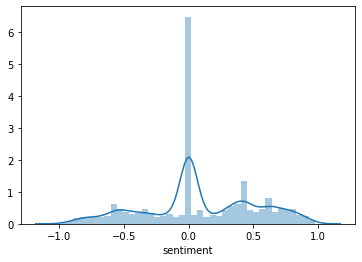

In [43]:
# view the distribution of sentiment in the dataset
sns.distplot(data["sentiment"])

Many of the tweets have neutral or mild sentiment, and aren't really interesting from a sentiment perspective. This is common for text data.

#### Learner challenge: categorise the tweets based on their sentiment

In [44]:
# add a positive/negative/neutral label to each tweet

def get_sentiment_type(score):
    if score >= 0.3:
        return "positive"
    elif score <= -0.3:
        return "negative"
    else:
        return "neutral"

data["sentiment_type"] = data["sentiment"].apply(get_sentiment_type)

In [45]:
# check the data
data[["text", "sentiment", "sentiment_type"]].sample(2)

,text,sentiment,sentiment_type
7969,Anyone else having issues with this? I’m conne...,0.4767,positive
6504,@apple if y’all don’t fix this automatic answe...,-0.6908,negative


## Calculating frequencies

In [46]:
# select the data we want to analyse
# here, we select only tweets with a positive sentiment
selection = data["tokens"][data["sentiment_type"] == "positive"]

In [47]:
# join all the tokens together into a list of lists
token_col = selection.to_list()

In [48]:
# flatten the list into a single list of tokens
tokens = list(flatten(token_col))

In [49]:
# count how many times each token appears
# this creates a dictionary with entries of the form (token: count)
token_counts = Counter(tokens)

In [50]:
# convert the counter dictionary into a sortable series
token_counts = pd.Series(token_counts)
print(token_counts)

true            42
likely           6
overpriced       7
latest          18
iphones         53
                ..
centered         1
accomplished     1
pocketable       1
operated         1
dimensions       1
Length: 7097, dtype: int64


### Visualise the top 20 words

#### Challenge: extract the 20 most frequent terms

In [51]:
# get the top 20 terms
top_twenty = token_counts.sort_values(ascending = False)[:20]

#### Challenge: create a barplot of top 10 terms & frequencies

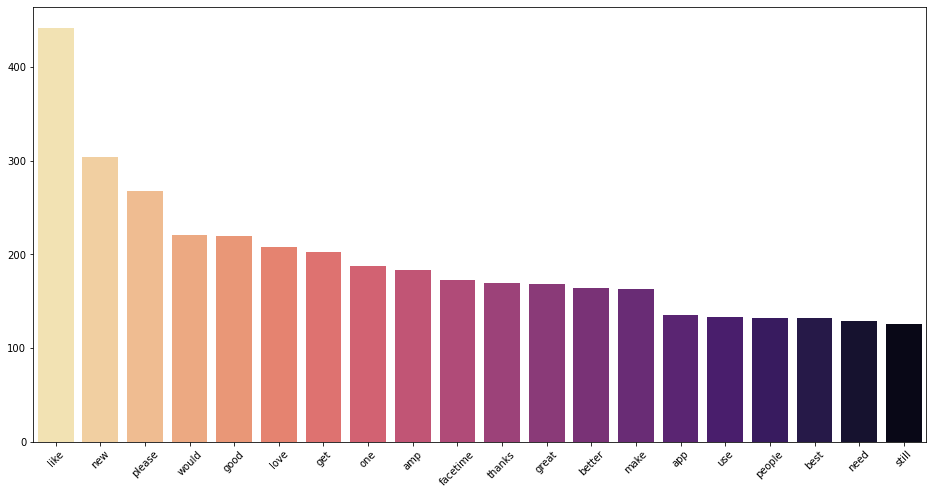

In [52]:
# plot them as a barplot
plt.figure(figsize = (16, 8))
plt.xticks(rotation = 45)
sns.barplot(x = top_twenty.index, y = top_twenty, palette = "magma_r")
plt.show()

## Summary:

In this workshop, we covered:
* Text filtering and normalisation using regular expressions
* Stopwords removal
* Tokenisation
* Sentiment scoring
* Word frequencies extraction and various visualisations

See you in the Online Practice!